In [249]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize, regexp_tokenize
import os
import joblib
import numpy as np
import spacy
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import random
import requests

In [250]:
# Downloads necessários do NLTK
print("Baixando recursos do NLTK...")
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Configurações gerais para visualização
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Carregar o modelo do spaCy
print("Carregando modelo do spaCy...")
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # Desativar componentes desnecessários para acelerar

# Stopwords
sw = set(stopwords.words("english"))

Baixando recursos do NLTK...
Carregando modelo do spaCy...


# 1. CARREGAR E SELECIONAR O DATASET (3% do Total)

In [251]:
print("Carregar dataset completo em partes...")
chunksize = 100000  # Processar em lotes de 100.000 linhas
data_chunks = []
for chunk in pd.read_csv('complaints.csv', chunksize=chunksize):
    chunk = chunk.dropna(subset=["narrative"])
    data_chunks.append(chunk)
data = pd.concat(data_chunks, ignore_index=True)

print("\nTotal de linhas no dataset original:", len(data))

Carregar dataset completo em partes...

Total de linhas no dataset original: 2023066


In [252]:
# Calcular o número de linhas para 3% do dataset
total_lines = len(data)  # Tamanho total do dataset
target_lines = int(total_lines * 0.0003)  # 3% do dataset
print(f"Target de linhas para 3% do dataset: {target_lines} linhas")

Target de linhas para 3% do dataset: 606 linhas


In [253]:
# Distribuição desejada das classes
class_distribution = {
    "Credit Reporting": 0.596,  # 59,6%
    "Debt Collection": 0.132,   # 13,2%
    "Loans": 0.113,             # 11,3%
    "Credit Card Services": 0.081,  # 8,1%
    "Bank Accounts and Services": 0.078  # 7,8%
}

In [254]:
# Calcular o número de exemplos por classe
class_counts = {cls: int(target_lines * proportion) for cls, proportion in class_distribution.items()}

# Selecionar os dados de acordo com a distribuição
selected_data = []
for cls, count in class_counts.items():
    class_data = data[data["product_5"] == cls]
    class_sample = class_data.sample(n=count, random_state=42)
    selected_data.append(class_sample)
data_selected = pd.concat(selected_data, ignore_index=True)

class_counts_actual = data_selected["product_5"].value_counts()
print(class_counts_actual)
print(class_counts_actual / len(data_selected))  # Proporção, como no Notebook 2

product_5
Credit Reporting              361
Debt Collection                79
Loans                          68
Credit Card Services           49
Bank Accounts and Services     47
Name: count, dtype: int64
product_5
Credit Reporting              0.597682
Debt Collection               0.130795
Loans                         0.112583
Credit Card Services          0.081126
Bank Accounts and Services    0.077815
Name: count, dtype: float64


In [255]:
# Encontrar uma reclamação pequena nas 20 primeiras reclamações para guardar como exemplo
complaint_index = None
for complaint_index in range(20):
    example_complaint = data_selected["narrative"].iloc[i]
    if len(example_complaint) < 150:
        print("Tamanho da reclamação:", len(example_complaint))
        print("Classe:", data_selected["product_5"].iloc[i])
        print("\nReclamação para exemplos:\n", example_complaint)
        break

Tamanho da reclamação: 141
Classe: Credit Reporting

Reclamação para exemplos:
 How can inquiries be a matter of public record if they are not accurate Equifax refuses to investigate claiming the above Photo copy uploaded


# 2. PRÉ-PROCESSAMENTO (Lemmatization)

In [256]:
# Definir o padrão de regex
REGEX_PATTERN = r'''(?x)
    (?:[A-Z]\.)+
    | \w+(?:-\w+)*
    | \$?\d+(?:\.\d+)?%?
    | \.\.\.
    | [][.,;"'?():-_`]
'''

In [257]:
# Função de pré-processamento (Lemmatization)
def preprocess_lemmatization(text):
    tokens = regexp_tokenize(str(text).lower(), REGEX_PATTERN)
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc if token.text not in sw and token.is_alpha]
    return ' '.join(tokens)

In [258]:
# Aplicar pré-processamento
file_name = "consumer_complaints_3percent_lem.csv"
column_name = "processed_text_lem"

if column_name not in data_selected.columns or not os.path.exists(file_name):
    corpus = [preprocess_lemmatization(review) for review in data_selected["narrative"]]
    data_selected[column_name] = corpus
    data_selected.to_csv(file_name, index=False)
    print(f"Corpus salvo como '{file_name}'.")
else:
    data_selected = pd.read_csv(file_name)
    print(f"Carregando corpus salvo de '{file_name}'.")

Corpus salvo como 'consumer_complaints_3percent_lem.csv'.


# 3. VETORIZAÇÃO (TF-IDF com N-gramas (1,3))

In [259]:
# Vetorizar com CountVectorizer
#vectorizer_temp = CountVectorizer(max_features=20)
#X_temp = vectorizer_temp.fit_transform(data_selected[column_name]).toarray()
#vocab = vectorizer_temp.get_feature_names_out()
#custom_stopwords = set(stopwords.words("english")) | {word for word in vocab if all(c == 'x' for c in word.lower())}

# Vetorizar com TF-IDF e N-gramas (1,3)
tfidf = TfidfVectorizer(max_features=4000, ngram_range=(1, 3), stop_words=list(sw))
X = tfidf.fit_transform(data_selected[column_name])
y = data_selected["product_5"]

# 4. OVERSAMPLING (3 Técnicas)

In [260]:
# Função para treinar e avaliar o XGBoost
def train_and_evaluate_xgboost(X, y, scenario_name):
    print(f"\n#### Treinando e Avaliando XGBoost - {scenario_name} ####")
    
    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # XGBoost
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train_enc)
    y_pred_enc = xgb.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)
    
    print(f"XGBoost ({scenario_name}):\n", classification_report(y_test, y_pred, zero_division=0))
    joblib.dump(xgb, f'xgboost_{scenario_name.lower().replace(" ", "_")}_3percent.joblib')

## 4.1 Infinite N-grams com Weighted Sampling

In [261]:
# Função para gerar uma reclamação sintética usando Infini-gram
def generate_synthetic_complaint(ngram, max_length=50, min_length=10):
    index = 'v4_rpj_llama_s4'  # Índice do Infini-gram
    text = ngram.split()
    
    # Gerar texto até atingir o comprimento máximo ou encontrar o token de fim
    attempts = 0
    max_attempts = 50  # Aumentando o número de tentativas
    while len(text) < max_length and text[-1] != "</s>" and attempts < max_attempts:
        payload = {
            'index': index,
            'query_type': 'infgram_ntd',
            'query': ' '.join(text[-5:]),  # Usar os últimos 5 tokens como contexto
        }
        try:
            result = requests.post('https://api.infini-gram.io/', json=payload).json()
            if 'result_by_token_id' not in result:
                print("Aviso: 'result_by_token_id' não encontrado na resposta da API.")
                break  # Parar se não houver mais tokens
            
            # Selecionar o próximo token com base nas probabilidades
            tokens = list(result['result_by_token_id'].values())
            probs = [t['prob'] for t in tokens]
            next_token = random.choices([t['token'] for t in tokens], weights=probs, k=1)[0]
            text.append(next_token)
            print(f"Token gerado (tentativa {attempts + 1}): {next_token}")  # Log para debugging
        except Exception as e:
            print(f"Erro ao chamar a API do Infini-gram: {e}")
            break
        attempts += 1
    
    # Pós-processamento para limpar tokens estranhos
    cleaned_text = [token for token in text if not token.startswith('<') and not token.startswith('▁')]
    if not cleaned_text or len(cleaned_text) < min_length:  # Verificar comprimento mínimo
        print("Aviso: Texto gerado muito curto ou vazio. Retornando a semente original.")
        return ngram
    return ' '.join(cleaned_text)

In [262]:
# Visualização: Gerar uma reclamação sintética a partir da primeira reclamação
example_complaint_processed = preprocess_lemmatization(example_complaint)
print("\nReclamação de exemplo processada (Lemmatization):\n", example_complaint_processed)


Reclamação de exemplo processada (Lemmatization):
 inquiry matter public record accurate equifax refuse investigate claim photo copy upload


In [263]:
# Usar os primeiros 5 tokens como semente
seed = ' '.join(example_complaint_processed.split()[:5])
print(f"\nSemente para Infini-gram (primeiros 5 tokens):\n{seed}")


Semente para Infini-gram (primeiros 5 tokens):
inquiry matter public record accurate


In [264]:
# Gerar reclamação sintética
synthetic_complaint = generate_synthetic_complaint(seed)
print("\nReclamação sintética gerada com Infini-gram:\n", synthetic_complaint)

Token gerado (tentativa 1): .
Token gerado (tentativa 2): ▁Digital
Token gerado (tentativa 3): ▁journalist
Token gerado (tentativa 4): ,
Token gerado (tentativa 5): ▁political
Token gerado (tentativa 6): ▁neutral
Token gerado (tentativa 7): ▁gas
Token gerado (tentativa 8): ▁
Token gerado (tentativa 9): ▁temperature
Token gerado (tentativa 10): ▁of
Token gerado (tentativa 11): ▁the
Token gerado (tentativa 12): ▁cool
Token gerado (tentativa 13): ing
Token gerado (tentativa 14): ▁and
Token gerado (tentativa 15): ▁
Token gerado (tentativa 16): ▁$\
Token gerado (tentativa 17): widehat
Token gerado (tentativa 18): ▁H
Token gerado (tentativa 19): =\
Token gerado (tentativa 20): sum
Token gerado (tentativa 21): mon
Token gerado (tentativa 22): et
Token gerado (tentativa 23): ary
Token gerado (tentativa 24): <0x0A>
Token gerado (tentativa 25): ▁CR
Token gerado (tentativa 26): AN
Token gerado (tentativa 27): NA
Token gerado (tentativa 28): ▁MO
Token gerado (tentativa 29): FI
Token gerado (tentat

In [265]:
# Criar uma tabela comparativa
comparison_data = {
    "Original": example_complaint_processed.split(),
    "Semente (5 tokens)": example_complaint_processed.split()[:5] + [''] * (len(example_complaint_processed.split()) - 5),
    "Sintética": synthetic_complaint.split() + [''] * (len(example_complaint_processed.split()) - len(synthetic_complaint.split()))
}
comparison_df = pd.DataFrame(comparison_data)
print("\nComparação entre Reclamação Original, Semente e Sintética:")
print(comparison_df)
comparison_df.to_csv("infgram_comparison.csv", index=False)

ValueError: All arrays must be of the same length

In [248]:
# Gerar reclamações sintéticas para balancear as classes
target_count = class_counts_actual.max()  # Balancear para a classe majoritária
synthetic_data = []

for cls in class_counts_actual.index:
    current_count = class_counts_actual[cls]
    to_generate = target_count - current_count
    if to_generate > 0:
        print(f"\nGerando {to_generate} reclamações sintéticas para a classe '{cls}'...")
        class_data = data_selected[data_selected["product_5"] == cls]
        for _ in range(to_generate):
            # Escolher uma reclamação aleatória da classe como semente
            seed_complaint = class_data.sample(1)["processed_text_lem"].iloc[0]
            seed = ' '.join(seed_complaint.split()[:5])
            synthetic_text = generate_synthetic_complaint(seed)
            synthetic_data.append({"processed_text_lem": synthetic_text, "product_5": cls})
            
# Adicionar as reclamações sintéticas ao dataset
data_infgram = pd.concat([data_selected, pd.DataFrame(synthetic_data)], ignore_index=True)


Gerando 282 reclamações sintéticas para a classe 'Debt Collection'...


KeyboardInterrupt: 

In [ ]:
# Verificar a nova distribuição
print("\nDistribuição das classes após oversampling com Infini-gram:")
print(data_infgram["product_5"].value_counts())

In [ ]:
# Visualização da distribuição
plt.figure()
sns.countplot(x="product_5", data=data_selected)
plt.title("Distribuição das Classes Antes do Oversampling (Infini-gram)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("class_distribution_before_infgram.png")
plt.show()

plt.figure()
sns.countplot(x="product_5", data=data_infgram)
plt.title("Distribuição das Classes Após Oversampling com Infini-gram")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("class_distribution_after_infgram.png")
plt.show()

In [ ]:
# Vetorizar o novo dataset
X_infgram = tfidf.transform(data_infgram["processed_text_lem"])
y_infgram = data_infgram["product_5"]

In [ ]:
# Treinar e avaliar
train_and_evaluate_xgboost(X_infgram, y_infgram, "Infini-gram Oversampling")

## 4.2 SMOTE (após TF-IDF)

In [266]:
# Função para mostrar as palavras mais importantes no vetor TF-IDF
def get_top_tfidf_words(vector, feature_names, top_n=5):
    indices = np.argsort(vector)[::-1][:top_n]
    return [(feature_names[i], vector[i]) for i in indices]

In [267]:
# Mostrar o vetor TF-IDF da reclamação de exemplo
example_complaint_vector = X[complaint_index].toarray().flatten()
feature_names = tfidf.get_feature_names_out()
top_words = get_top_tfidf_words(example_complaint_vector, feature_names, top_n=5)
print("\nReclamação de exemplo: ", data_selected["narrative"].iloc[complaint_index])
print("\nReclamação de exemplo processada (Lemmatization):\n", data_selected["processed_text_lem"].iloc[complaint_index])
print("\nTop 5 palavras com maiores pesos TF-IDF na reclamação de exemplo:")
for word, score in top_words:
    print(f"{word}: {score:.4f}")


Reclamação de exemplo:  By the provisions of the Fair Credit Reporting Act, I am submitting this complaint to request that the listed account which I believe appears to be inaccurate and incomplete be immediately investigated and corrected on my credit file. 
XXXX XXXX

Reclamação de exemplo processada (Lemmatization):
 provision fair credit reporting act submit complaint request list account believe appear inaccurate incomplete immediately investigate correct credit file xxxx xxxx

Top 5 palavras com maiores pesos TF-IDF na reclamação de exemplo:
investigate correct: 0.2635
file xxxx xxxx: 0.2482
account believe: 0.2482
provision: 0.2482
correct credit: 0.2421


In [268]:
# Encontrar o vizinho mais próximo manualmente (para ilustração)
from sklearn.neighbors import NearestNeighbors
class_label = y.iloc[complaint_index]
class_indices = np.where(y == class_label)[0]
X_class = X[class_indices].toarray()
nn = NearestNeighbors(n_neighbors=2)  # 2 porque o primeiro vizinho será o próprio exemplo
nn.fit(X_class)
distances, indices = nn.kneighbors(example_complaint_vector.reshape(1, -1))
neighbor_idx = class_indices[indices[0][1]]  # O segundo vizinho (o primeiro é o próprio exemplo)
neighbor_vector = X[neighbor_idx].toarray().flatten()
top_words_neighbor = get_top_tfidf_words(neighbor_vector, feature_names, top_n=5)
print("\nTop 5 palavras com maiores pesos TF-IDF no vizinho mais próximo:")
for word, score in top_words_neighbor:
    print(f"{word}: {score:.4f}")


Top 5 palavras com maiores pesos TF-IDF no vizinho mais próximo:
letter request: 0.2974
investigate correct: 0.2864
request account: 0.2698
file xxxx xxxx: 0.2698
account believe: 0.2698


In [269]:
# Simular a interpolação do SMOTE (fator aleatório fixo para ilustração)
random_factor = 0.5
synthetic_vector_manual = example_complaint_vector + random_factor * (neighbor_vector - example_complaint_vector)
top_words_synthetic_manual = get_top_tfidf_words(synthetic_vector_manual, feature_names, top_n=5)
print("\nTop 5 palavras com maiores pesos TF-IDF no exemplo sintético (simulação manual):")
for word, score in top_words_synthetic_manual:
    print(f"{word}: {score:.4f}")


Top 5 palavras com maiores pesos TF-IDF no exemplo sintético (simulação manual):
investigate correct: 0.2749
account believe: 0.2590
file xxxx xxxx: 0.2590
correct credit: 0.2526
inaccurate incomplete: 0.2471


In [ ]:
# Visualização com PCA antes do SMOTE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Class"] = y.values

# Identificar as coordenadas da reclamação de exemplo
example_complaint_pca = pca.transform(example_complaint_vector.reshape(1, -1))[0]
print("\nCoordenadas PCA da reclamação de exemplo antes do SMOTE:", example_complaint_pca)


Coordenadas PCA da reclamação de exemplo antes do SMOTE: [-0.10039457 -0.10506966]


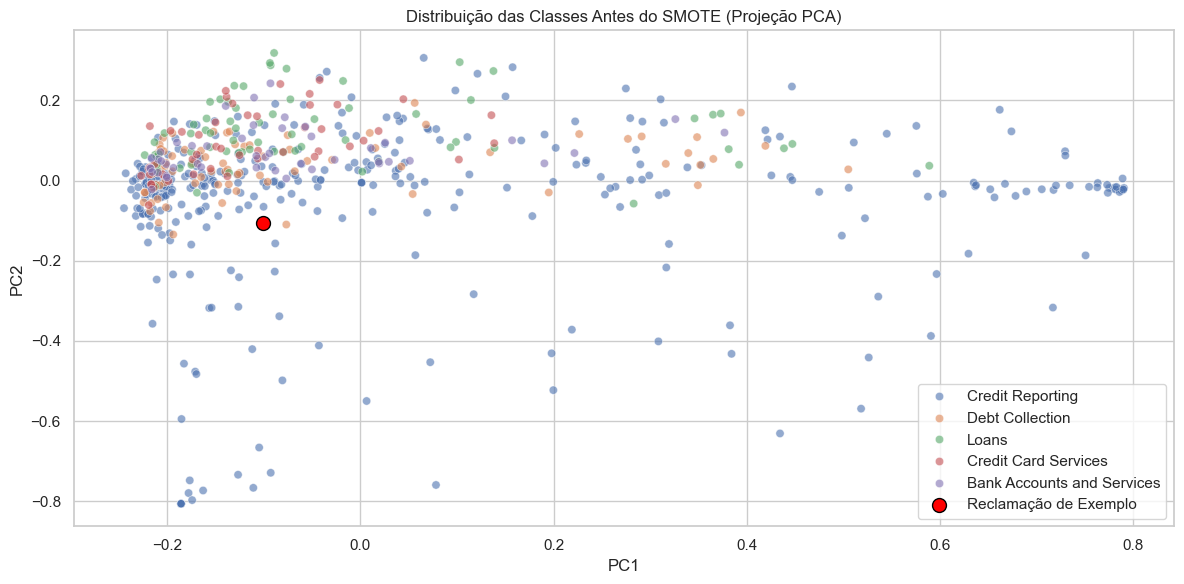

In [271]:
# Plotar com destaque para a reclamação de exemplo
plt.figure()
sns.scatterplot(x="PC1", y="PC2", hue="Class", data=df_pca, alpha=0.6)
plt.scatter(example_complaint_pca[0], example_complaint_pca[1], color='red', s=100, label='Reclamação de Exemplo', edgecolor='black')
plt.title("Distribuição das Classes Antes do SMOTE (Projeção PCA)")
plt.legend()
plt.tight_layout()
plt.savefig("smote_before_pca.png")
plt.show()

In [272]:
# Aplicar SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X, y)

In [273]:
# Visualização com PCA após o SMOTE
X_smote_pca = pca.transform(X_smote.toarray())
df_smote_pca = pd.DataFrame(X_smote_pca, columns=["PC1", "PC2"])
df_smote_pca["Class"] = y_smote

In [274]:
# Tentar encontrar um exemplo sintético próximo da reclamação de exemplo
distances = np.linalg.norm(X_smote_pca - example_complaint_pca, axis=1)
closest_synthetic_idx = np.argmin(distances[len(y):]) + len(y)  # Considerar apenas os exemplos sintéticos
closest_synthetic_pca = X_smote_pca[closest_synthetic_idx]
print("\nCoordenadas PCA do exemplo sintético mais próximo da reclamação de exemplo:", closest_synthetic_pca)


Coordenadas PCA do exemplo sintético mais próximo da reclamação de exemplo: [-0.08156056 -0.09912553]


In [275]:
# Mostrar o vetor TF-IDF do exemplo sintético
closest_synthetic_vector = X_smote[closest_synthetic_idx].toarray().flatten()
top_words_synthetic = get_top_tfidf_words(closest_synthetic_vector, feature_names, top_n=5)
print("\nTop 5 palavras com maiores pesos TF-IDF no exemplo sintético mais próximo:")
for word, score in top_words_synthetic:
    print(f"{word}: {score:.4f}")


Top 5 palavras com maiores pesos TF-IDF no exemplo sintético mais próximo:
usc: 0.3387
cease: 0.2965
information credit reporting: 0.2872
accurate information: 0.2561
xxxx xxxx violate: 0.2561


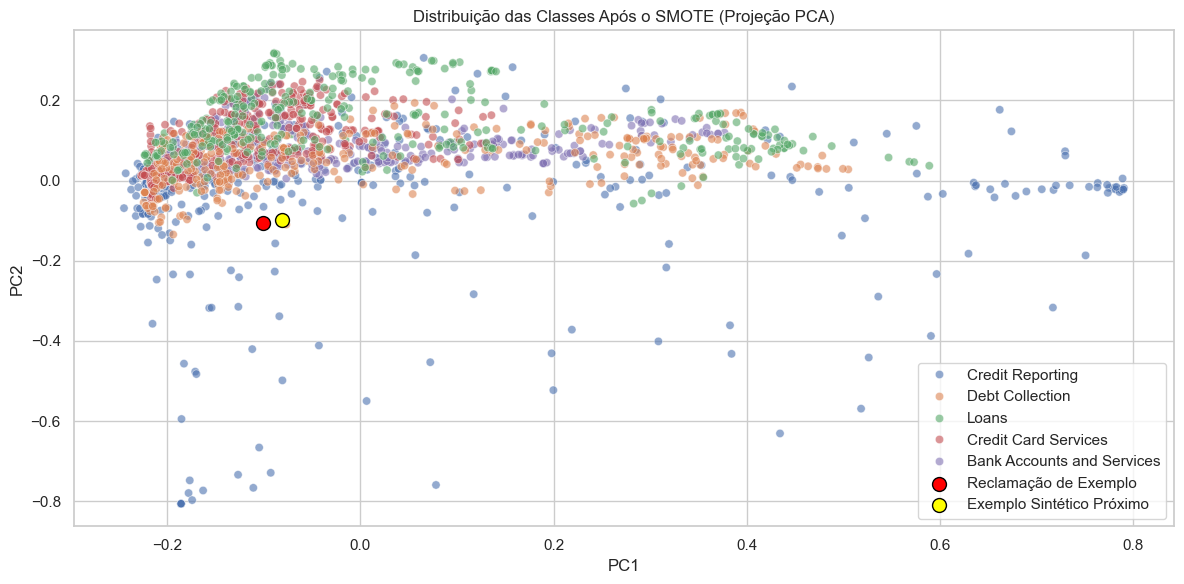

In [276]:
# Plotar com destaque para a reclamação de exemplo e o exemplo sintético
plt.figure()
sns.scatterplot(x="PC1", y="PC2", hue="Class", data=df_smote_pca, alpha=0.6)
plt.scatter(example_complaint_pca[0], example_complaint_pca[1], color='red', s=100, label='Reclamação de Exemplo', edgecolor='black')
plt.scatter(closest_synthetic_pca[0], closest_synthetic_pca[1], color='yellow', s=100, label='Exemplo Sintético Próximo', edgecolor='black')
plt.title("Distribuição das Classes Após o SMOTE (Projeção PCA)")
plt.legend()
plt.tight_layout()
plt.savefig("smote_after_pca.png")
plt.show()

In [277]:
# Verificar a nova distribuição
print("\nDistribuição das classes após SMOTE:")
print(pd.Series(y_smote).value_counts())


Distribuição das classes após SMOTE:
product_5
Credit Reporting              361
Debt Collection               361
Loans                         361
Credit Card Services          361
Bank Accounts and Services    361
Name: count, dtype: int64


In [278]:
# Treinar e avaliar
def train_and_evaluate_xgboost(X, y, scenario_name):
    print(f"\n#### Treinando e Avaliando XGBoost - {scenario_name} ####")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train_enc)
    y_pred_enc = xgb.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)
    print(f"XGBoost ({scenario_name}):\n", classification_report(y_test, y_pred, zero_division=0))
    joblib.dump(xgb, f'xgboost_{scenario_name.lower().replace(" ", "_")}_3percent.joblib')

train_and_evaluate_xgboost(X_smote, y_smote, "SMOTE Oversampling")


#### Treinando e Avaliando XGBoost - SMOTE Oversampling ####


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (SMOTE Oversampling):
                             precision    recall  f1-score   support

Bank Accounts and Services       1.00      0.94      0.97        68
      Credit Card Services       0.98      0.97      0.98        65
          Credit Reporting       0.85      0.81      0.83        70
           Debt Collection       0.90      0.92      0.91        79
                     Loans       0.93      1.00      0.96        79

                  accuracy                           0.93       361
                 macro avg       0.93      0.93      0.93       361
              weighted avg       0.93      0.93      0.93       361



## 4.3 Batch com Distribuição Equitativa por Classe

In [279]:
# Verificar a distribuição atual
print("\nDistribuição das classes antes do oversampling equitativo:")
print(class_counts_actual)


Distribuição das classes antes do oversampling equitativo:
product_5
Credit Reporting              361
Debt Collection                79
Loans                          68
Credit Card Services           49
Bank Accounts and Services     47
Name: count, dtype: int64


In [280]:
# Definir o número alvo (classe majoritária)
target_count = class_counts_actual.max()
print(f"\nNúmero alvo de exemplos por classe (baseado na classe majoritária): {target_count}")


Número alvo de exemplos por classe (baseado na classe majoritária): 361


In [281]:
# Balancear as classes para ter a mesma quantidade por classe
data_equitative = []
repetition_counts = {}  # Para rastrear quantas vezes cada exemplo foi repetido

for cls in class_counts_actual.index:
    class_data = data_selected[data_selected["product_5"] == cls]
    current_count = len(class_data)
    print(f"\nClasse '{cls}': {current_count} exemplos (faltam {target_count - current_count} para atingir o alvo)")
    
    if current_count < target_count:
        # Oversampling: repetir exemplos até atingir o target
        oversampled_data = class_data.sample(target_count - current_count, replace=True, random_state=42)
        # Rastrear repetições
        for idx in oversampled_data.index:
            if idx in repetition_counts:
                repetition_counts[idx] += 1
            else:
                repetition_counts[idx] = 1
        data_equitative.append(pd.concat([class_data, oversampled_data], ignore_index=True))
    else:
        data_equitative.append(class_data)

data_equitative = pd.concat(data_equitative, ignore_index=True)


Classe 'Credit Reporting': 361 exemplos (faltam 0 para atingir o alvo)

Classe 'Debt Collection': 79 exemplos (faltam 282 para atingir o alvo)

Classe 'Loans': 68 exemplos (faltam 293 para atingir o alvo)

Classe 'Credit Card Services': 49 exemplos (faltam 312 para atingir o alvo)

Classe 'Bank Accounts and Services': 47 exemplos (faltam 314 para atingir o alvo)


In [282]:
# Verificar a nova distribuição
print("\nDistribuição das classes após oversampling equitativo:")
print(data_equitative["product_5"].value_counts())


Distribuição das classes após oversampling equitativo:
product_5
Credit Reporting              361
Debt Collection               361
Loans                         361
Credit Card Services          361
Bank Accounts and Services    361
Name: count, dtype: int64


In [283]:
# Mostrar exemplos repetidos
print("\nExemplos mais repetidos após oversampling equitativo:")
repetition_df = pd.DataFrame.from_dict(repetition_counts, orient='index', columns=['Frequência'])
repetition_df = repetition_df.sort_values(by='Frequência', ascending=False).head(5)
for idx in repetition_df.index:
    print(f"Exemplo (índice {idx}): Repetido {repetition_df.loc[idx, 'Frequência']} vezes")
    print(f"Texto: {data_selected.loc[idx, 'processed_text_lem']}")
    print(f"Classe: {data_selected.loc[idx, 'product_5']}\n")


Exemplos mais repetidos após oversampling equitativo:
Exemplo (índice 501): Repetido 12 vezes
Texto: xxxx xxxx xxxx xxxx xxxx loan xxxx request approve forebearance xxxx xxxx xxxx due covid nearing end forebearance xxxx xxxx apply trial modification xxxx approve trial modification lower monthly mortgage note trial modification payment begin xx xx xxxx receive specific instruction loan transfer loancare xxxx ongoing modification payment send loan care receive notice approval trial modification service transfer notice xx xx xxxx try send payment per instruction loan care every trial modification payment reject return since xxxx contact multiple time try resolve issue since divorce work together conference call speak attorney resolve matter provide loan care document xxxx xxxx show transfer modification authorize user xxxx account life loan judgment multiple email call complaint still resolution loancare pull xxxx credit without permission xx xx xxxx website show receive document need un

In [284]:
# Verificar se a reclamação de exemplo foi repetida
if complaint_index in repetition_counts:
    print(f"\nA reclamação de exemplo (índice {complaint_index}) foi repetida {repetition_counts[complaint_index]} vezes.")
else:
    print(f"\nA reclamação de exemplo (índice {complaint_index}) não foi repetida (provavelmente porque pertence à classe majoritária).")


A reclamação de exemplo (índice 0) não foi repetida (provavelmente porque pertence à classe majoritária).


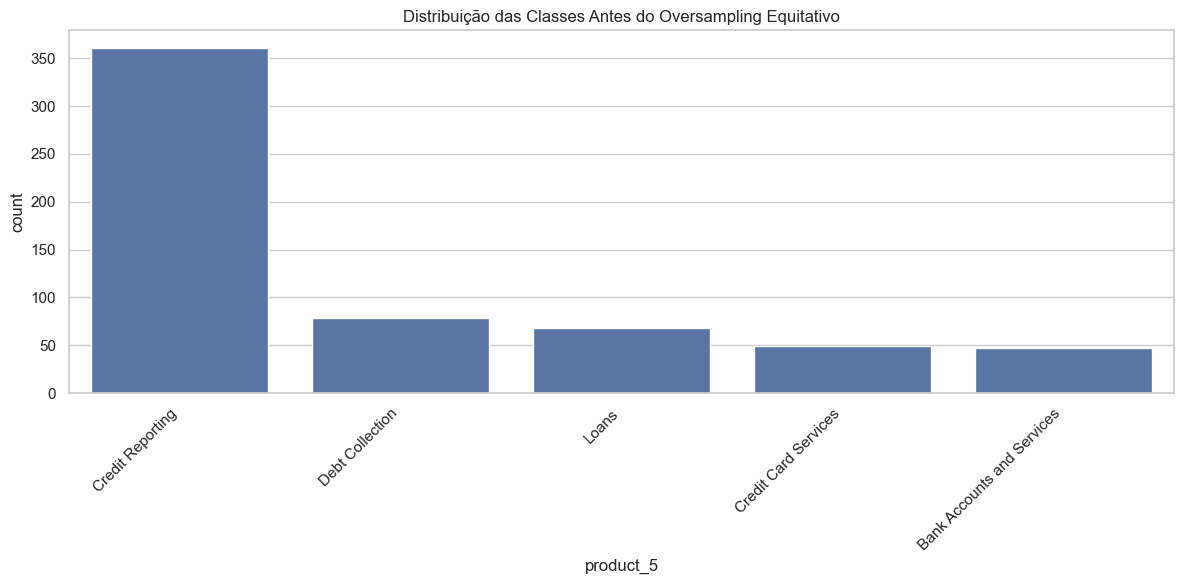

In [285]:
# Visualização da distribuição
plt.figure()
sns.countplot(x="product_5", data=data_selected)
plt.title("Distribuição das Classes Antes do Oversampling Equitativo")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("class_distribution_before_equitative.png")
plt.show()

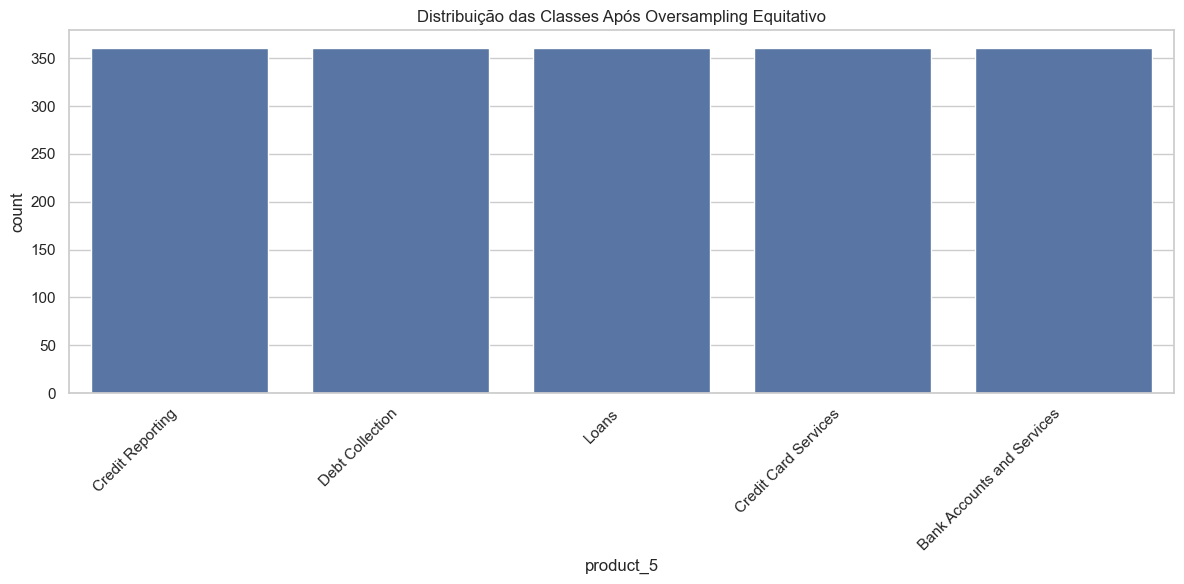

In [286]:
plt.figure()
sns.countplot(x="product_5", data=data_equitative)
plt.title("Distribuição das Classes Após Oversampling Equitativo")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("class_distribution_after_equitative.png")
plt.show()

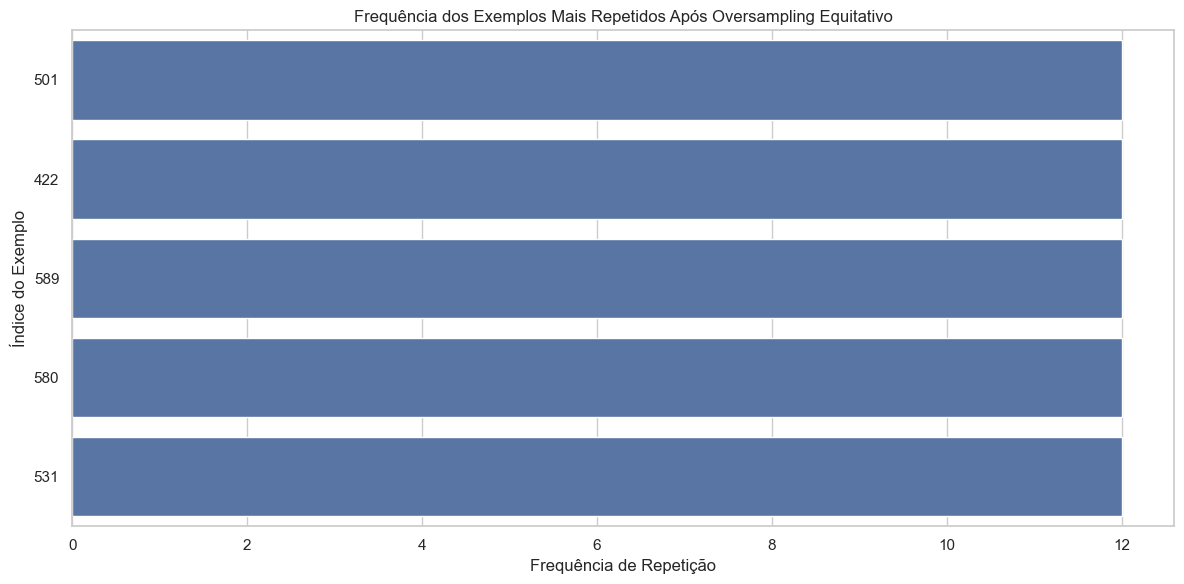

In [287]:
# Visualizar a frequência de repetição dos exemplos mais repetidos
plt.figure()
sns.barplot(x=repetition_df['Frequência'], y=repetition_df.index.astype(str))
plt.title("Frequência dos Exemplos Mais Repetidos Após Oversampling Equitativo")
plt.xlabel("Frequência de Repetição")
plt.ylabel("Índice do Exemplo")
plt.tight_layout()
plt.savefig("equitative_repetition_frequency.png")
plt.show()

In [288]:
# Vetorizar o novo dataset
X_equitative = tfidf.transform(data_equitative["processed_text_lem"])
y_equitative = data_equitative["product_5"]

# Treinar e avaliar
train_and_evaluate_xgboost(X_equitative, y_equitative, "Equitative Batch Oversampling")


#### Treinando e Avaliando XGBoost - Equitative Batch Oversampling ####


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (Equitative Batch Oversampling):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.99      1.00      0.99        81
      Credit Card Services       0.95      1.00      0.98        63
          Credit Reporting       1.00      0.84      0.91        70
           Debt Collection       0.96      1.00      0.98        80
                     Loans       0.94      1.00      0.97        67

                  accuracy                           0.97       361
                 macro avg       0.97      0.97      0.97       361
              weighted avg       0.97      0.97      0.97       361



In [289]:
# Salvar dataset final
data_equitative.to_csv("consumer_complaints_3percent_processed.csv", index=False)
print("\nDataset processado salvo como 'consumer_complaints_3percent_processed.csv'.")


Dataset processado salvo como 'consumer_complaints_3percent_processed.csv'.
